In [1]:
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import svm
from sklearn import metrics, tree
from imblearn.under_sampling import RandomUnderSampler
from shap import plots, Explanation, KernelExplainer
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle
import shap
from utils import *

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_dict, usecols=selected_features),
    pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_dict, usecols=selected_features)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783531 entries, 0 to 783530
Data columns (total 81 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   flow_duration             783531 non-null  float64
 1   fwd_pkts_tot              783531 non-null  uint64 
 2   bwd_pkts_tot              783531 non-null  uint64 
 3   fwd_data_pkts_tot         783531 non-null  uint64 
 4   bwd_data_pkts_tot         783531 non-null  uint64 
 5   fwd_pkts_per_sec          783531 non-null  float64
 6   bwd_pkts_per_sec          783531 non-null  float64
 7   flow_pkts_per_sec         783531 non-null  float64
 8   down_up_ratio             783531 non-null  float32
 9   fwd_header_size_tot       783531 non-null  uint64 
 10  fwd_header_size_min       783531 non-null  uint8  
 11  fwd_header_size_max       783531 non-null  uint8  
 12  bwd_header_size_tot       783531 non-null  uint64 
 13  bwd_header_size_min       783531 non-null  u

In [4]:
ds.describe()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,7.835310e+05,783531.000000,7.835310e+05,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,7.835310e+05,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000
mean,7.930232,15.141476,15.202140,6.076205,11.985713,2.457452e+03,1960.277241,4.417729e+03,0.828711,5.221322e+02,23.148409,28.325925,4.665602e+02,18.626142,22.381593,0.778524,1.156447,0.418391,5.386756,8.314095,28.377589,0.001020,0.000008,0.001668,0.000037,17.793925,193.943558,1.685628e+03,45.600529,53.879600,22.216197,1167.560257,1.975559e+04,266.243447,343.753524,17.805741,1178.124581,2.144121e+04,159.531792,275.836606,7.863213e+05,4.496497e+06,7.770665e+06,1.097694e+06,9.087544e+05,2.396059e+04,3.669306e+06,5.969705e+06,3.493875e+05,9.122481e+05,7.861756e+05,4.575104e+06,7.941801e+06,9.855074e+05,6.942865e+05,7.737873e+04,10.765978,10.812873,1144.741004,1.200525e+04,23.553719,4.742144e+03,0.034943,1.864668,6.219484e+03,4.144654e+06,6.273139e+05,8.291515e+05,9.390527e+05,7.090896e+05,1.153479e+05,3.233009e+06,4.344537e+06,7.002749e+06,3.663116e+06,5.879498e+05,25885.029520,26880.533083,7417.383553
std,97.220072,390.717612,395.026085,62.401492,393.515497,2.913841e+04,5229.838478,3.047502e+04,0.492997,1.484319e+04,12.629693,15.981276,1.259048e+04,12.781371,16.568396,0.999198,1.029890,0.812277,62.129340,145.891623,785.296047,0.032707,0.002767,0.048602,0.006490,32.828224,300.906381,6.378143e+04,62.585370,91.086309,43.025812,2464.742493,3.385688e+05,509.497456,595.534119,32.883272,2464.226347,3.469619e+05,258.848209,477.557042,6.638000e+06,2.064076e+07,9.716466e+07,6.798270e+06,4.600532e+06,8.692441e+05,1.961555e+07,6.336533e+07,1.924652e+06,4.739904e+06,6.637222e+06,2.069169e+07,9.722218e+07,6.707441e+06,3.368079e+06,3.841924e+06,71.788091,75.387846,14402.013478,1.259423e+05,976.003926,

In [5]:
ds.columns

Index(['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd

We can see from this graph that we don't have highly correlated features.

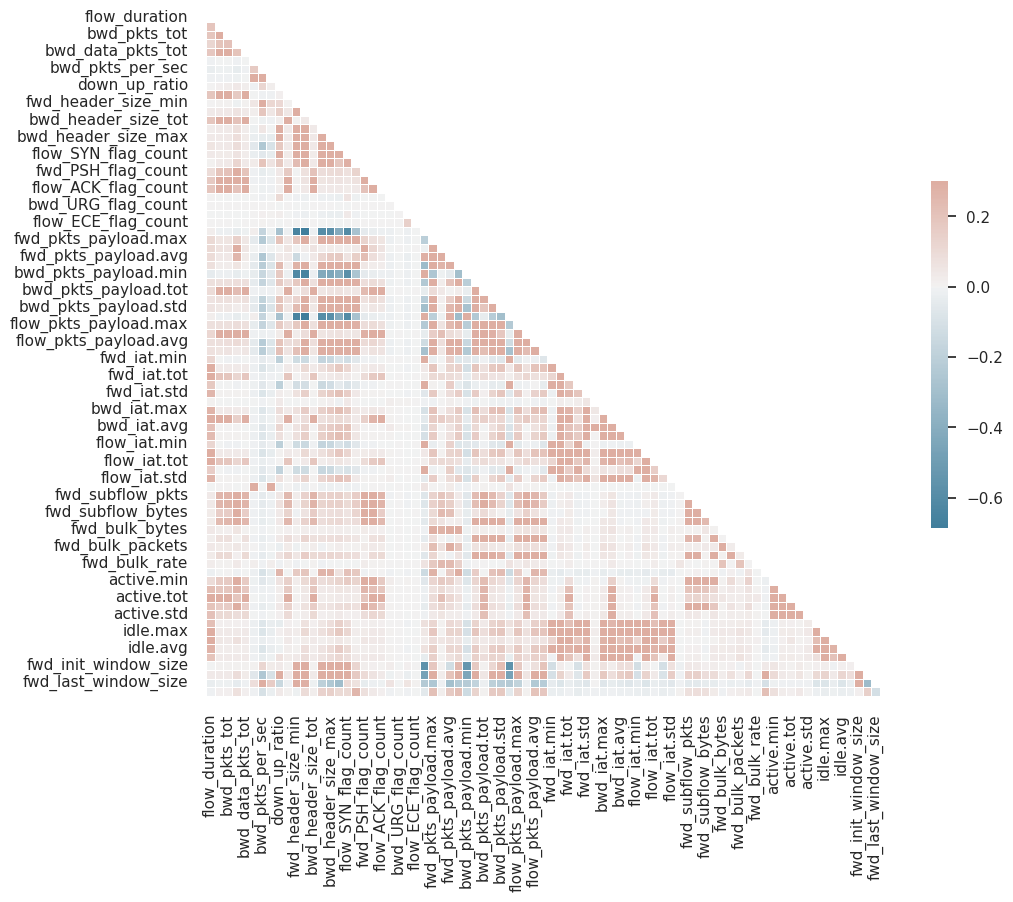

In [6]:
show_corr_matrix(ds)

In [7]:
compute_ratio(ds)

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [8]:
params = { 
    "C": 20
}

In [9]:
scaler = StandardScaler()
scaler.fit(ds[x_features])

StandardScaler()

In [10]:
svc = svm.SVC(**params)
pv = DataPreprocessingAndValidation(ds, 7988, 5, svm.SVC, params, scaler=scaler)

In [11]:
X_res, y_res = pv.get_undersampled_ds()
scaled_undersampled = scaler.transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(scaled_undersampled, ds.loc[y_res.index].Label, test_size = 0.2, random_state=12,  stratify=ds.loc[y_res.index].traffic_category)

In [12]:
if False:
    cv = 10
    visualizer = LearningCurve(estimator=svc, cv=cv, scoring='f1', n_jobs=-1, random_state=123)
    visualizer.fit(X_train, y_train)
    visualizer.show(outpath="svc_data/learning_curve.png")

![Alt text](svc_data/learning_curve.png)

In [13]:
%time pv.cross_validation(ds[x_features], ds.Label, y_res)

Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
CPU times: user 5min 25s, sys: 3.29 s, total: 5min 28s
Wall time: 1min 29s


(0.9306332473008367, 0.0017596279708228246, 88.84340167045593)

In [14]:
%time svc.fit(X_train, y_train)

CPU times: user 1min 8s, sys: 756 ms, total: 1min 9s
Wall time: 18.4 s


SVC(C=20)

In [15]:
%time y_predicted_train = svc.predict(X_train)
%time y_predicted_test = svc.predict(X_test)

CPU times: user 4.87 s, sys: 4.03 ms, total: 4.87 s
Wall time: 1.22 s
CPU times: user 1.34 s, sys: 135 µs, total: 1.34 s
Wall time: 336 ms


In [16]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.926647,0.925593
1,PRECISION,0.873259,0.871686
2,RECALL,0.998161,0.998122
3,F1 SCORE,0.931542,0.930630
4,AUC,0.926649,0.925587


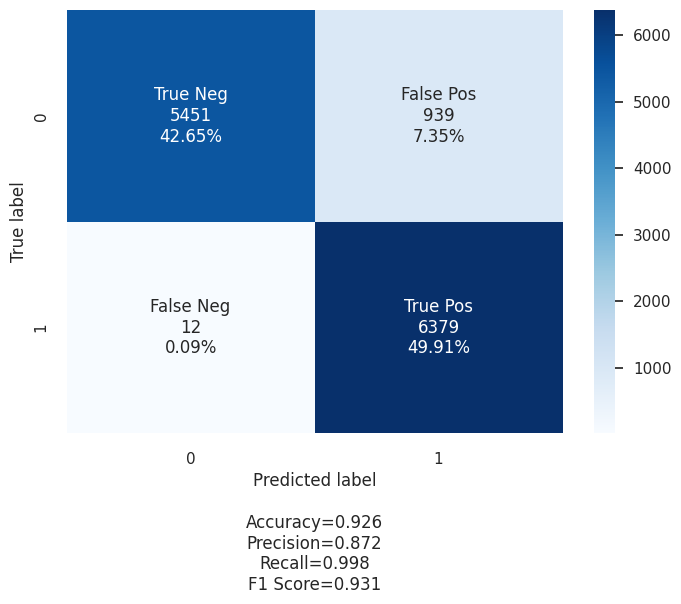

In [17]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [18]:
if True:
    scaled_ds = scaler.transform(X_train)

    kmeans = KMeans(n_clusters=100, random_state=0).fit(scaled_ds)
    foreground = shap.sample(X_train, 100)
    
    explainer = KernelExplainer(svc.predict, kmeans.cluster_centers_)
    sv = explainer.shap_values(foreground)

    exp = Explanation(sv,
                  explainer.expected_value,
                  data=foreground, 
                  feature_names=x_features)

    exp.base_values = np.array([exp.base_values])
    
    with open('svc_data/exp.pickle', 'wb') as handle:
        pickle.dump(exp, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('svc_data/exp.pickle', 'rb') as handle:
        exp = pickle.load(handle)

X does not have valid feature names, but StandardScaler was fitted with feature names
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
100%|██████████| 100/100 [09:37<00:00,  5.77s/it]


In [19]:
if False:
    kmeans = KMeans(n_clusters=100, random_state=0).fit(scaled_ds)

    exp_list = []

    for k in range(10):
        foreground = shap.sample(X_train, 100)

        explainer = KernelExplainer(svc.predict, kmeans.cluster_centers_)
        sv = explainer.shap_values(foreground)

        exp = Explanation(sv,
                      explainer.expected_value,
                      data=foreground,
                      feature_names=x_features)

        exp.base_values = np.array([exp.base_values])
        exp_list.append(exp)
        
    with open('svc_data/exp_list.pickle', 'wb') as handle:
        pickle.dump(exp_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("jumping the test")

jumping the test


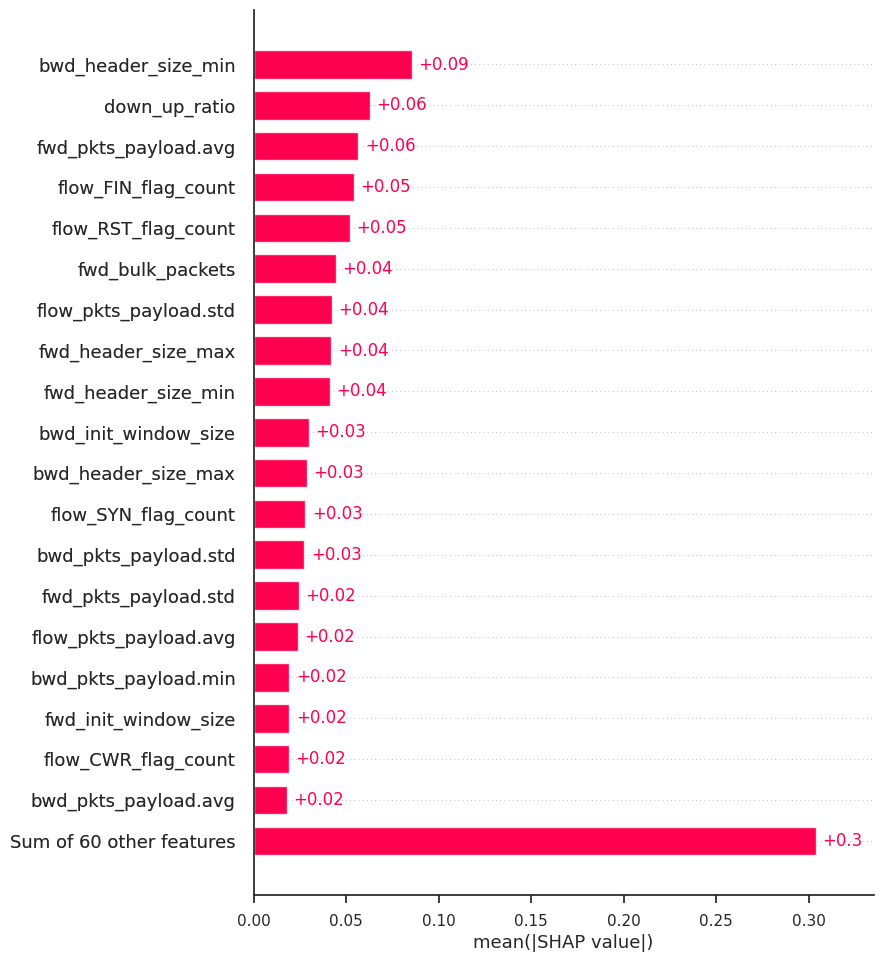

In [20]:
plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

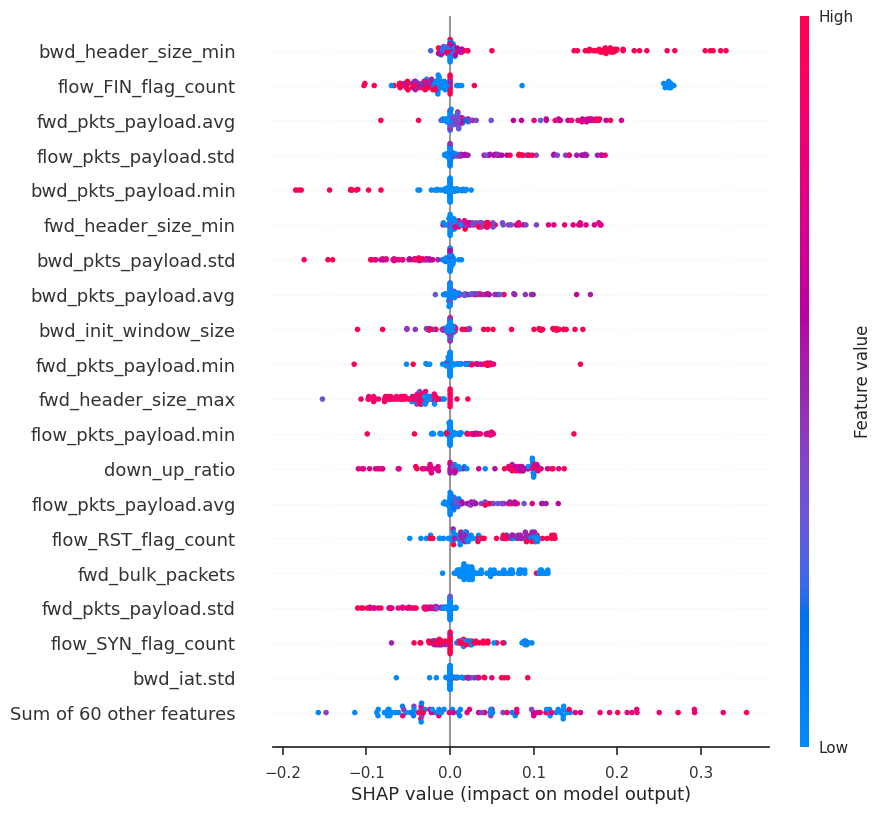

In [21]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

In [22]:
pv.feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
pv.feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
13,0.085374,bwd_header_size_min
8,0.062772,down_up_ratio
28,0.056505,fwd_pkts_payload.avg
15,0.054149,flow_FIN_flag_count
17,0.052014,flow_RST_flag_count
62,0.044248,fwd_bulk_packets
39,0.042289,flow_pkts_payload.std
11,0.041955,fwd_header_size_max
10,0.041297,fwd_header_size_min
77,0.029902,bwd_init_window_size


In [23]:
pv.feature_above_zero = pv.feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [24]:
%%time

if True:
    result = pv.recursive_reduction()
    feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})
    
    with open('svc_data/feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('svc_data/feature_reduction_scores.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)

Running the cross validation
testing with 79 features
Running the cross validation
testing with 78 features
Running the cross validation
testing with 77 features
Running the cross validation
testing with 76 features
Running the cross validation
testing with 75 features
Running the cross validation
testing with 74 features
Running the cross validation
testing with 73 features
Running the cross validation
testing with 72 features
Running the cross validation
testing with 71 features
Running the cross validation
testing with 70 features
Running the cross validation
testing with 69 features
Running the cross validation
testing with 68 features
Running the cross validation
testing with 67 features
Running the cross validation
testing with 66 features
Running the cross validation
testing with 65 features
Running the cross validation
testing with 64 features
Running the cross validation
testing with 63 features
Running the cross validation
testing with 62 features
Running the cross validation

<Axes: xlabel='n_features', ylabel='cv_time'>

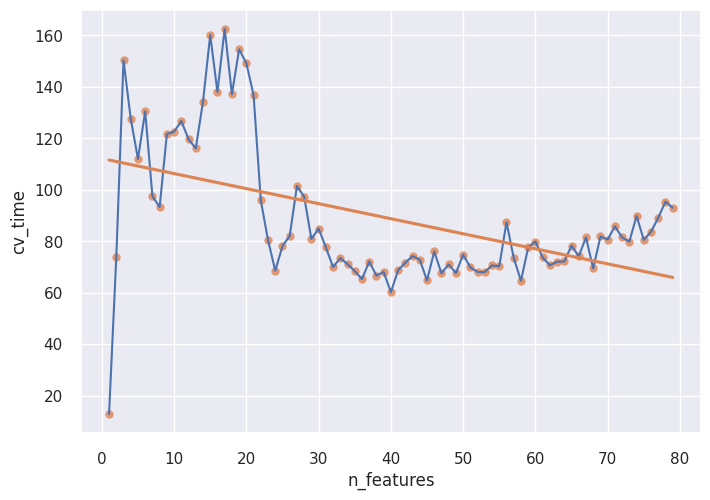

In [25]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

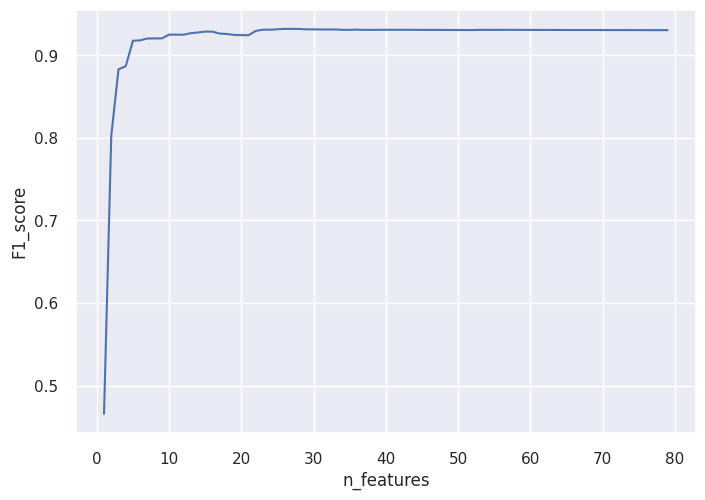

In [26]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

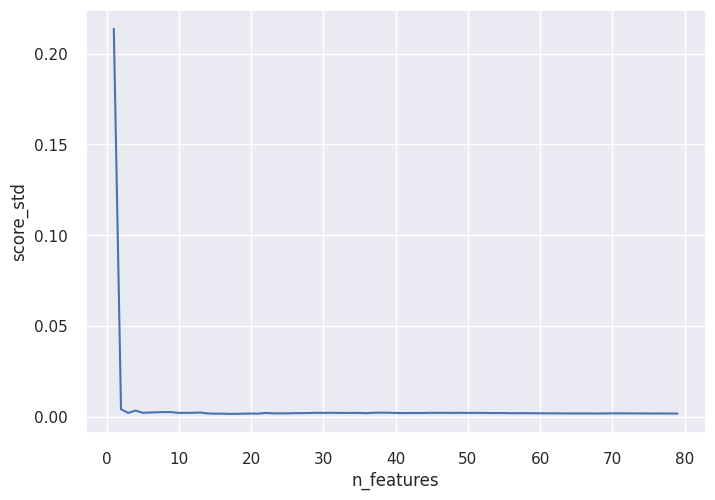

In [27]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [28]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
53,0.932168,0.001962,26,82.113710
52,0.932139,0.002002,27,101.477876
51,0.932044,0.002029,28,97.310016
54,0.931684,0.001849,25,78.143210
50,0.931602,0.002154,29,80.853654
...,...,...,...,...
74,0.917782,0.002153,5,111.986334
75,0.886917,0.003416,4,127.651767
76,0.883147,0.002081,3,150.296431
77,0.802673,0.004137,2,73.695354


In [29]:
%%time

if True:
    zero_day_feature_reduction_scores = pv.run_zero_day_test()
    with open('svc_data/zero_day_feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('svc_data/zero_day_feature_reduction_scores.pickle', 'rb') as handle:
        zero_day_feature_reduction_scores = pickle.load(handle)

traing for  XMRIGCC CryptoMiner
training with 79 features
Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
training with 78 features
Running the cross validation
training with 77 features
Running the cross validation
training with 76 features
Running the cross validation
training with 75 features
Running the cross validation
training with 74 features
Running the cross validation
training with 73 features
Running the cross validation
training with 72 features
Running the cross validation
training with 71 features
Running the cross validation
training with 70 features
Running the cross validation
training with 69 features
Running the cross validation
training with 68 features
Running the cross validation
training with 67 features
Running the cross validation
training with 66 features
Running the cross validation
training with 65 features
Running the cross validation
training with 64 features
Running the cross validation
training with 63 features
Ru

In [30]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [31]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
157,0.801425,0.999875,0.668704,0.697642,0.052024,1,Probing,4.662277,0.461342,1
236,0.801425,0.999875,0.668704,0.671651,0.003176,1,Bruteforce,5.128279,0.372826,1
314,0.805102,0.999624,0.673953,0.801746,0.003962,2,Bruteforce-XML,9.147660,0.225099,1
235,0.699829,0.769654,0.641620,0.818565,0.005899,2,Bruteforce,12.031742,0.159868,1
313,0.496947,0.422884,0.602461,0.869219,0.006967,3,Bruteforce-XML,25.100132,0.247814,1
...,...,...,...,...,...,...,...,...,...,...
186,0.000220,0.000125,0.000920,0.934305,0.004375,51,Bruteforce,11.719525,0.245201,1
187,0.000220,0.000125,0.000920,0.934195,0.004364,50,Bruteforce,15.056257,0.255488,1
188,0.000220,0.000125,0.000920,0.934195,0.004364,49,Bruteforce,11.234425,0.221418,1
189,0.000220,0.000125,0.000920,0.934195,0.004364,48,Bruteforce,14.277937,0.224182,1


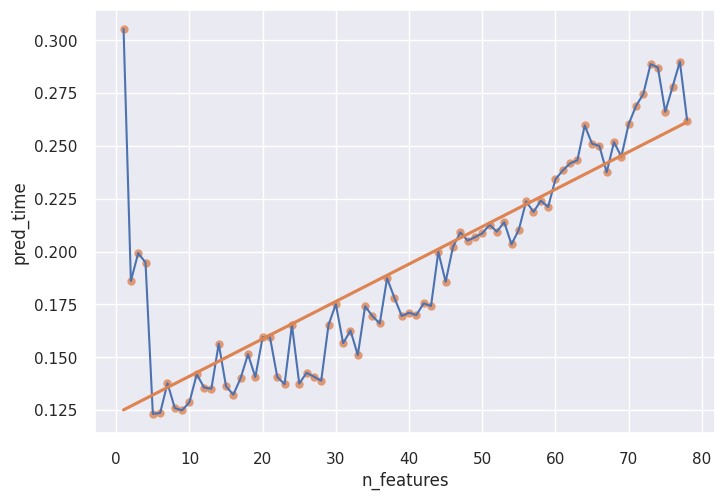

In [32]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

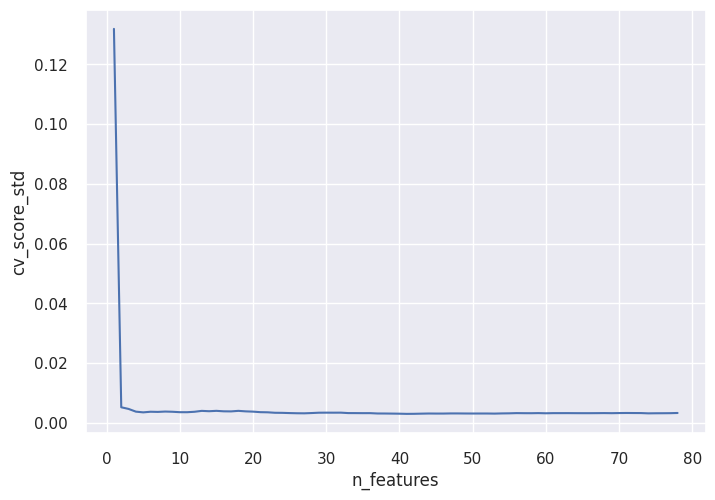

In [33]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [34]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
1,0.400712,0.499937,0.334352,0.646007,0.131875,3.550868,0.305401,0.50
2,0.435921,0.490986,0.406057,0.825788,0.005174,9.591239,0.186093,0.75
3,0.151505,0.122277,0.227947,0.904172,0.004619,16.759223,0.199280,0.75
6,0.160375,0.121307,0.267167,0.935814,0.003677,18.128233,0.123621,0.75
5,0.135946,0.096082,0.255674,0.935672,0.003471,12.870056,0.123201,0.75
...,...,...,...,...,...,...,...,...
55,0.000442,0.000250,0.001930,0.946849,0.003147,10.436037,0.210391,0.75
54,0.000442,0.000250,0.001929,0.946807,0.003117,13.035873,0.203416,0.75
57,0.000440,0.000250,0.001812,0.946964,0.003193,11.065697,0.218741,0.50


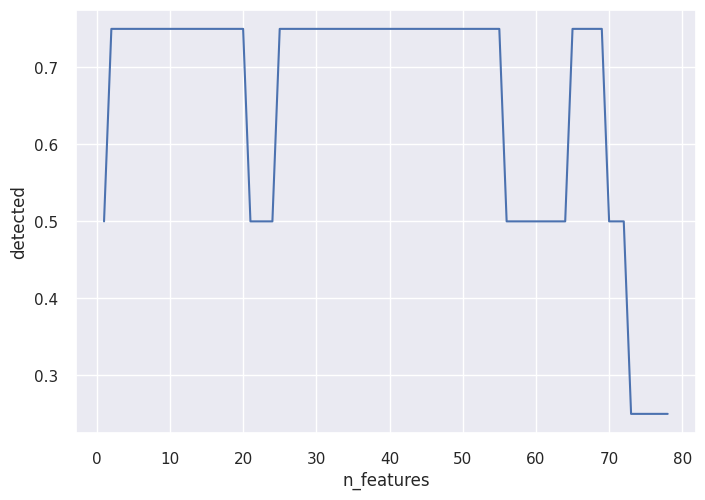

In [35]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

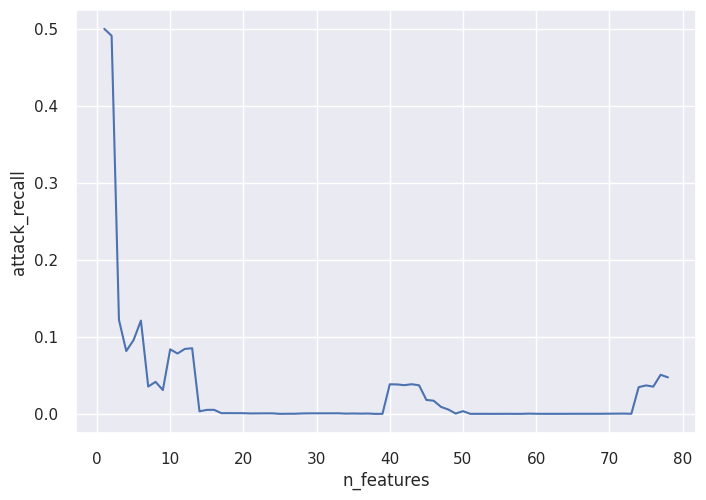

In [36]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [37]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time
n_features,,,,,,,
2,0.435921,0.490986,0.406057,0.825788,0.005174,9.591239,0.186093
1,0.400712,0.499937,0.334352,0.646007,0.131875,3.550868,0.305401
6,0.160375,0.121307,0.267167,0.935814,0.003677,18.128233,0.123621
3,0.151505,0.122277,0.227947,0.904172,0.004619,16.759223,0.199280
5,0.135946,0.096082,0.255674,0.935672,0.003471,12.870056,0.123201
...,...,...,...,...,...,...,...
55,0.000442,0.000250,0.001930,0.946849,0.003147,10.436037,0.210391
54,0.000442,0.000250,0.001929,0.946807,0.003117,13.035873,0.203416
57,0.000440,0.000250,0.001812,0.946964,0.003193,11.065697,0.218741


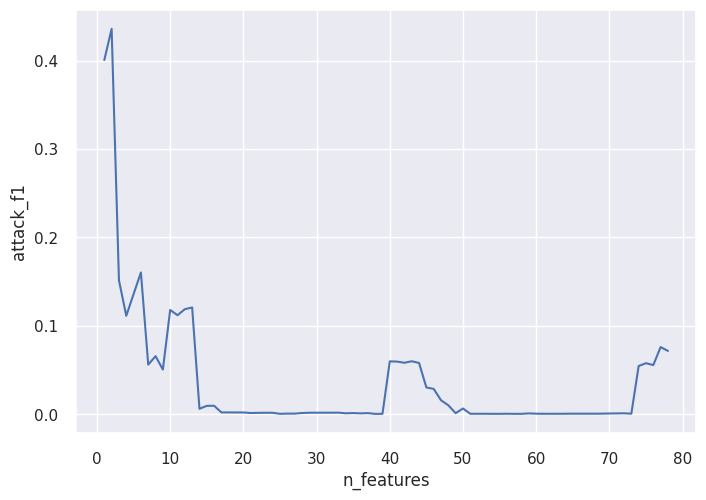

In [38]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [43]:
zero_day_feature_reduction_scores.query('n_features == 6')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
73,0.000000,0.000000,0.000000,0.952597,0.002530,6,XMRIGCC CryptoMiner,17.978569,0.076053,0
152,0.009620,0.005383,0.045168,0.940196,0.003918,6,Probing,10.377147,0.129929,1
231,0.104039,0.062719,0.304930,0.931383,0.004188,6,Bruteforce,20.714119,0.128708,1
310,0.527842,0.417126,0.718568,0.919079,0.004070,6,Bruteforce-XML,23.443098,0.159792,1


In [40]:
zero_day_feature_reduction_scores.query('n_features == 7')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
72,0.000000,0.000000,0.000000,0.954991,0.002249,7,XMRIGCC CryptoMiner,9.513713,0.099472,0
151,0.010092,0.005633,0.048387,0.942470,0.004275,7,Probing,7.579822,0.102237,1
230,0.011570,0.006635,0.045145,0.932652,0.004325,7,Bruteforce,13.081875,0.172349,1
309,0.202623,0.130571,0.452102,0.921556,0.003635,7,Bruteforce-XML,20.126048,0.176721,1


In [41]:
zero_day_feature_reduction_scores.query('n_features == 8')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
71,0.000000,0.000000,0.000000,0.955339,0.002281,8,XMRIGCC CryptoMiner,9.593728,0.076710,0
150,0.008981,0.005008,0.043478,0.942694,0.004274,8,Probing,7.511568,0.103316,1
229,0.038524,0.022409,0.137165,0.932273,0.004538,8,Bruteforce,17.254927,0.161345,1
308,0.215272,0.139584,0.470266,0.921655,0.003859,8,Bruteforce-XML,18.966214,0.162423,1


In [42]:
zero_day_feature_reduction_scores.query('n_features == 79')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
0,0.000000,0.000000,0.00000,0.966117,0.001552,79,XMRIGCC CryptoMiner,9.266473,0.176625,0
79,0.000000,0.000000,0.00000,0.954429,0.003454,79,Probing,8.011897,0.229024,0
158,0.000000,0.000000,0.00000,0.934085,0.004257,79,Bruteforce,18.644358,0.351459,0
237,0.224846,0.144216,0.50996,0.931903,0.003659,79,Bruteforce-XML,16.483797,0.372842,1
